# Wind-driven upwelling - 2 layer analysis

***

In [145]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import NEMO_upwelling_postprocessing as ps
from matplotlib import colors
from copy import copy
from scipy.interpolate import griddata
from salishsea_tools import viz_tools

%matplotlib inline

In [156]:
plt.rcParams['font.size'] = 12

***

## Load and process results

The processing code can be found in `analysis-ben/modules/NEMO_upwelling_postprocessing.py` and the code development is documented in `analysis-ben/notebooks/SOG_upwelling_paperfigs/NEMO_postprocessing.ipynb`

Load netCDF files and define global parameters

In [3]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

Calculate coastline indices

In [4]:
# Calculate coastline indices
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)
sections = ps.calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

Process idealized 2-layer stratification runs

In [5]:
# Process idealized 2-layer results
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}
runs_idealized = ps.process_idealized_results(param, sections, mask, grids, keys=['z_h', 'rho_s', 'u_wind'])

Processing the hindcast results takes about 1.5 hours, so I've previously saved those processed results to a netCDF file.

In [6]:
# Process hindcast results (or load from netCDF)
#runs = ps.process_hindcast_results(events_southerly, sections, mask, HRDPS)
runs_hindcast = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/notebooks/SOG_upwelling_paperfigs/hindcast_processed.nc')

***

## Plot idealized results

Spatial dependence plotting functions

In [136]:
def plot_bathymetry(fig, ax, bathy, tmask):
    """
    """
    
    # Plot landmask and bathymetry
    c = ax.contourf(bathy, cmap='YlGnBu', levels=np.arange(0, 451, 50), extend='max')
    ax.contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    
    # Formatting
    ax.set_xlim([110, 350])
    ax.set_xlabel('Subdomain grid X')
    viz_tools.set_aspect(ax)
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='Depth [m]')


def plot_contour(fig, ax, ftW, residual, jindex, label, levels=[-1.5, 1.6], xbar=0.1, xlim=[0, 3.2]):
    """
    """

    # Construct full jindex
    jfull = np.empty(0)
    for n in range(int(len(ftW) / len(jindex))):
        jfull = np.concatenate((jfull, jindex))
    
    # Interpolate upwelling variable to grid
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), jindex)
    data = griddata((ftW, jfull), residual, (xi, yi), method='linear')
    
    # Plot interpolated field and original datapoint locations
    c = ax.contourf(xi, yi, data, levels=np.arange(*levels, 0.1), cmap='coolwarm', extend='both')
    ax.plot(ftW, jfull, 'ko', markersize=2)
    
    # Formatting
    ax.set_xlim(xlim)
    ax.set_xlabel('$ft/W$')
    cax = fig.add_axes([xbar, 0.02, 0.2, 0.01])
    fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=[-1, 0, 1])

In [117]:
def plot_idealized_spatial(runs):
    """
    """
    
    # Make plots and format
    fig, axs = plt.subplots(1, 3, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([365, 715])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')

    # Plot coastline reference
    plot_bathymetry(fig, axs[2], bathy.Bathymetry, mask.tmask[0, ...])

    # Wind integration factor
    jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

    # Loop through pycnocline depth and surface layer density
    ftW, z_u, x_u = np.empty(0), np.empty(0), np.empty(0)
    for z_h in param['z_h']:
        for rho_s in param['rho_s']:

            # Calculate reduced gravity and Rossby radius
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_R = np.sqrt(g_prime * z_h) / const['f']

            # Loop through windspeed
            for U, tau in zip(param['u_wind'], param['tau']):

                # Calculate Wedderburn number predictor and observed upwelling/offshore advection
                ftW = np.concatenate((ftW, tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))))
                z_u = np.concatenate((z_u, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                x_u = np.concatenate((x_u, np.array(runs[z_h][rho_s][U]['x_u']) / L_R))
    
    # Interpolate to contour grid and plot results
    labels = ['$z_u/z_h - ft/W$', '$x_u/L_R - ft/W + 1$']
    x1, x2 = copy(ftW), copy(ftW)
    x1[x1 > 1], x2[x2 < 1] = 1, 1
    for ax, residual, label, xbar in zip(axs[:2], [z_u-x1, x_u-x2+1], labels, [0.145, 0.415]):
        plot_contour(fig, ax, ftW, residual, sections['ji'][0], label, xbar=xbar)

    return fig, axs

***

### Basic plot

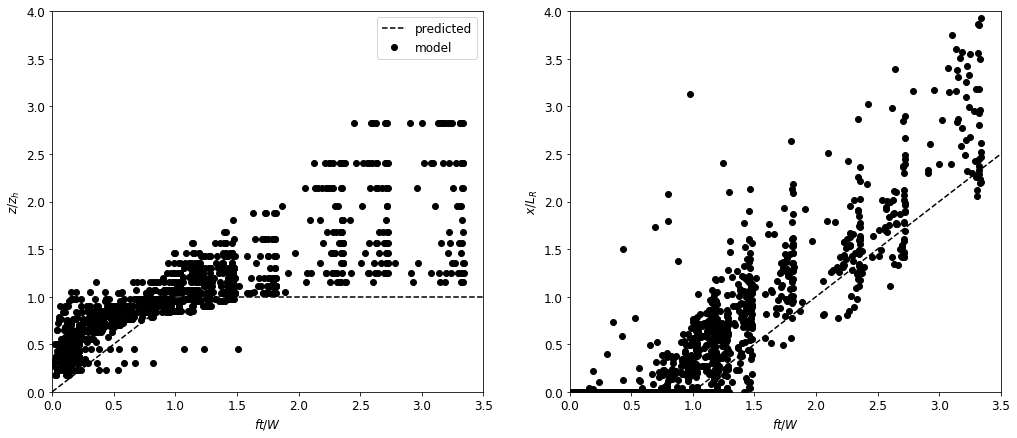

In [99]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
axs[0].plot([0, 1], [0, 1], 'k--', label='predicted')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)

# Define tau j component
jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

# Loop through run parameters
k = 0
for z_h in param['z_h']:
    for rho_s in param['rho_s']:
        
        # Define reduced gravity and internal Rossby radius
        g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
        L_R = np.sqrt(g_prime * z_h) / const['f']
        
        # Loop through windspeed, windstress
        for U, tau in zip(param['u_wind'], param['tau']):
            
            # Define upwelling predictor and plot
            label = 'model' if k == 0 else None
            k += 1
            ftW = tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
            for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
                ax.plot(ftW, np.array(runs_idealized[z_h][rho_s][U][var]) / scale, 'ko', label=label)

# Make legend
axs[0].legend()
plt.show()

### Spatial dependence

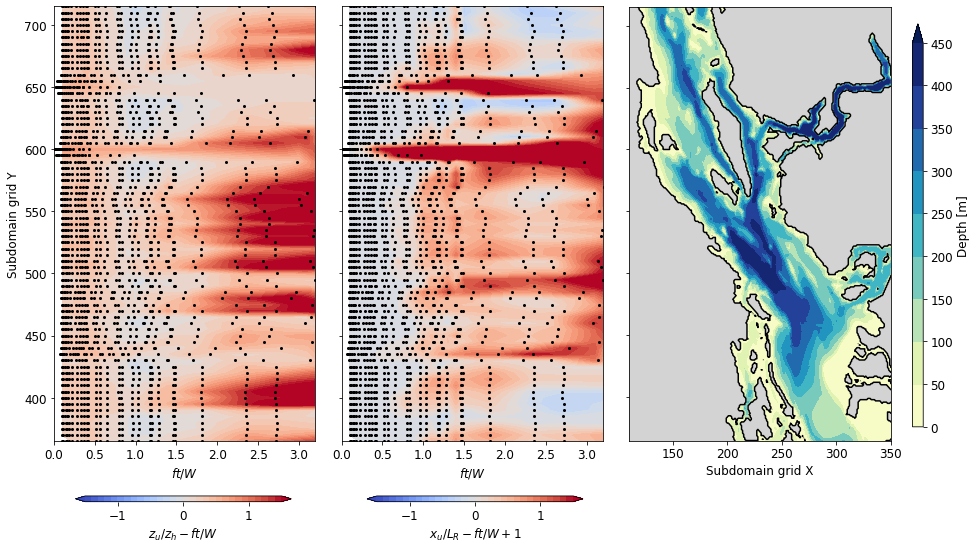

In [118]:
fig, axs = plot_idealized_spatial(runs_idealized)
#fig.savefig('/home/bmoorema/Desktop/idealized_results.pdf', bbox_inches='tight')

### Topographic dependence

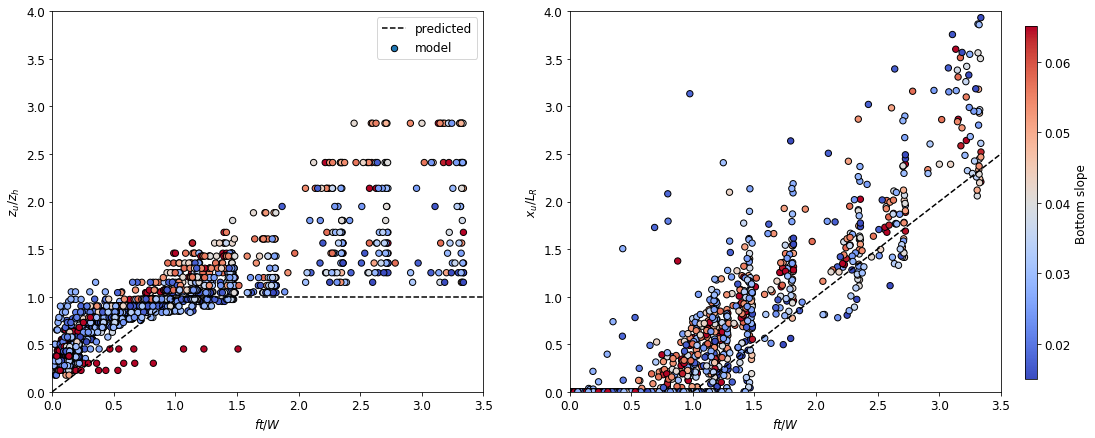

In [115]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
axs[0].plot([0, 1], [0, 1], 'k--', label='predicted')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')
for ax, ylabel in zip(axs, ['$z_u/z_h$', '$x_u/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)

# Define tau j component
jtau = np.sin(np.arctan(2) - sections['angle']) * (hour - 3) * 3600

# Loop through run parameters
k = 0
for z_h in param['z_h']:
    for rho_s in param['rho_s']:
        
        # Define reduced gravity and internal Rossby radius
        g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
        L_R = np.sqrt(g_prime * z_h) / const['f']
        
        # Loop through windspeed, windstress
        for U, tau in zip(param['u_wind'], param['tau']):
            
            # Define upwelling predictor and plot
            label = 'model' if k == 0 else None
            k += 1
            ftW = tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
            for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
                c = ax.scatter(
                    ftW, np.array(runs_idealized[z_h][rho_s][U][var]) / scale,
                    s=40, c=sections['slope'], vmin=0.015, vmax=0.065,
                    edgecolor='k', cmap='coolwarm', label=label,
                )

# Make legend
axs[0].legend()
fig.colorbar(c, cax=cax, label='Bottom slope')
plt.show()

***

## Plot hindcast results

Spatial dependence plotting functions

In [143]:
def plot_hindcast_spatial(runs, levels=[-1.4, 1.5], xlim=[0, 2.2]):
    """
    """
    
    # Make plots and format
    fig, axs = plt.subplots(1, 3, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([365, 715])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')

    # Plot coastline reference
    plot_bathymetry(fig, axs[2], bathy.Bathymetry, mask.tmask[0, ...])

    # Calculate Wedderburn number predictor and observed upwelling/offshore advection
    z_h = runs_hindcast.z_h.values.flatten()
    g_prime = const['g'] * (const['rho_0'] - runs_hindcast.rho_s.values.flatten()) / const['rho_0']
    L_R = np.sqrt(g_prime * z_h) / const['f']
    ftW = runs_hindcast.tau.values.flatten() / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
    z_u = runs_hindcast.z_u.values.flatten() / z_h
    x_u = runs_hindcast.x_u.values.flatten() / L_R
    
    # Interpolate to contour grid and plot results
    labels = ['$z_u/z_h - ft/W$', '$x_u/L_R - ft/W + 1$']
    x1, x2 = copy(ftW), copy(ftW)
    x1[x1 > 1], x2[x2 < 1] = 1, 1
    for ax, residual, label, xbar in zip(axs[:2], [z_u-x1, x_u-x2+1], labels, [0.145, 0.415]):
        plot_contour(fig, ax, ftW, residual, sections['ji'][0], label, levels=levels, xbar=xbar, xlim=xlim)

    return fig, axs

***

### Basic plot

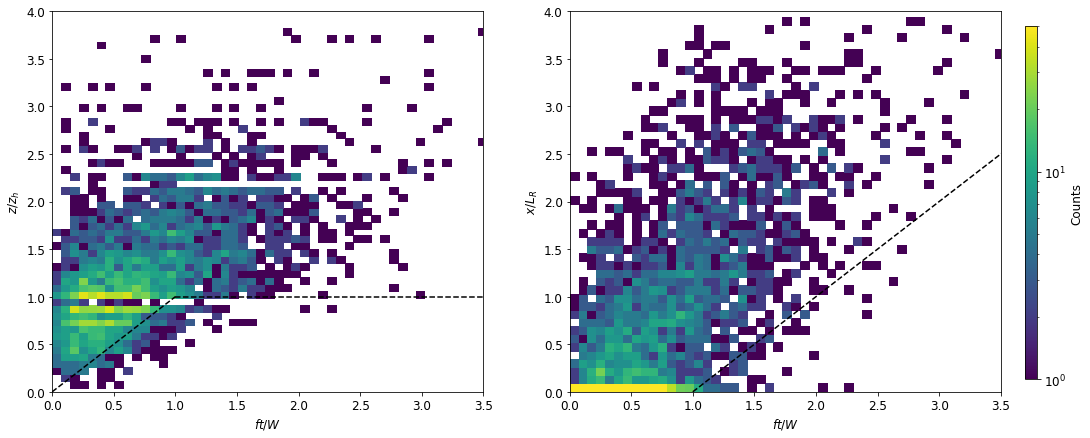

In [161]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
axs[0].plot([0, 1], [0, 1], 'k--', label='predicted')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')

# Calculate Wedderburn number predictor and observed upwelling/offshore advection
z_h = runs_hindcast.z_h.values
g_prime = const['g'] * (const['rho_0'] - runs_hindcast.rho_s.values) / const['rho_0']
L_R = np.sqrt(g_prime * z_h) / const['f']
ftW = runs_hindcast.tau.values / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))

for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
    _, _, _, c = ax.hist2d(
        ftW.flatten(), runs_hindcast[var].values.flatten() / scale.flatten(),
        norm=colors.LogNorm(vmin=1, vmax=50), bins=70,
    )

# Formatting
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)
fig.colorbar(c, cax=cax, label='Counts')
plt.show()

### Spatial dependence

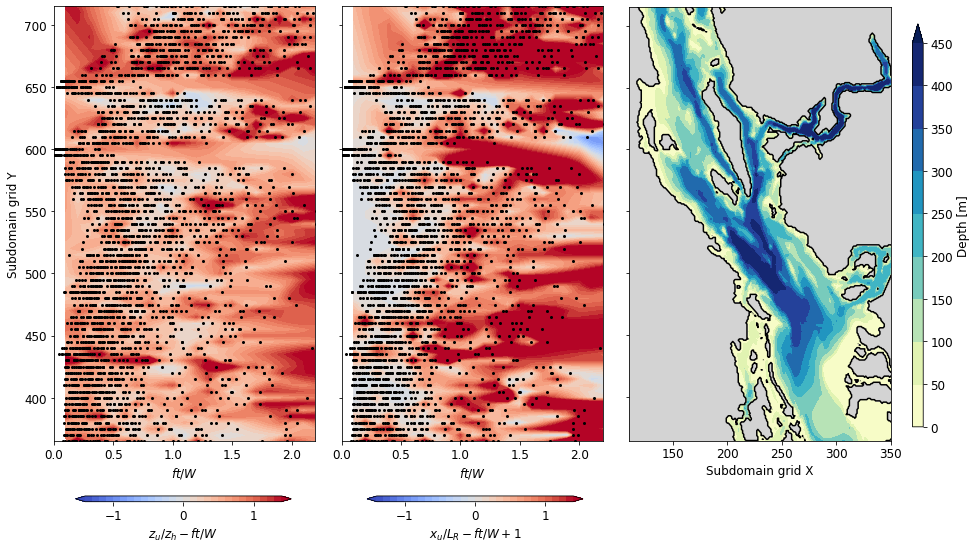

In [144]:
fig, axs = plot_hindcast_spatial(runs_hindcast)

### Topographic dependence

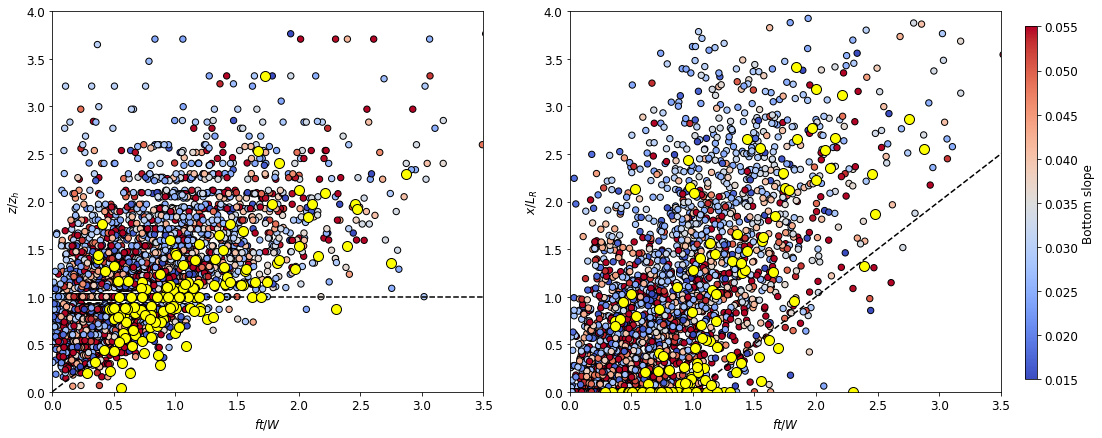

In [212]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
axs[0].plot([0, 1], [0, 1], 'k--', label='predicted')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')

# Calculate Wedderburn number predictor and observed upwelling/offshore advection
z_h = runs_hindcast.z_h.values
g_prime = const['g'] * (const['rho_0'] - runs_hindcast.rho_s.values) / const['rho_0']
L_R = np.sqrt(g_prime * z_h) / const['f']
ftW = runs_hindcast.tau.values / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))

# Build slope array
slope = np.empty(0)
for n in range(len(runs_hindcast.date)):
    slope = np.concatenate((slope, sections['slope']))
index = slope < 0.013

for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
    c = ax.scatter(
        ftW.flatten(), runs_hindcast[var].values.flatten() / scale.flatten(),
        s=40, c=slope, vmin=0.015, vmax=0.055, edgecolor='k', cmap='coolwarm',
    )
    ax.plot(
        ftW.flatten()[index], (runs_hindcast[var].values.flatten() / scale.flatten())[index],
        'ko', markerfacecolor='yellow', markersize=10,
    )

# Formatting
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)
fig.colorbar(c, cax=cax, label='Bottom slope')
plt.show()

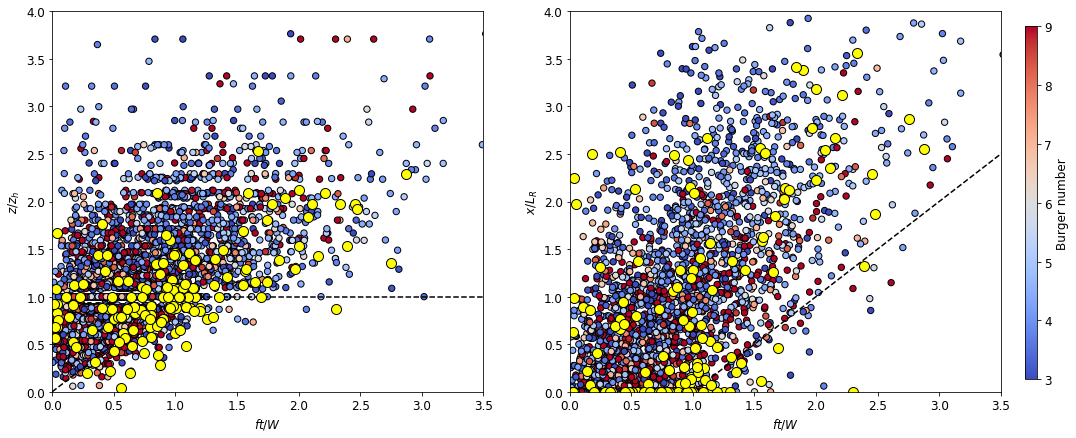

In [224]:
# Make figure panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
axs[0].plot([0, 1], [0, 1], 'k--', label='predicted')
axs[0].plot([1, 4], [1, 1], 'k--')
axs[1].plot([1, 4], [0, 3], 'k--')

# Calculate Wedderburn number predictor and observed upwelling/offshore advection
z_h = runs_hindcast.z_h.values
g_prime = const['g'] * (const['rho_0'] - runs_hindcast.rho_s.values) / const['rho_0']
L_R = np.sqrt(g_prime * z_h) / const['f']
ftW = runs_hindcast.tau.values / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))

# Build slope array
slope = np.empty(0)
for n in range(len(runs_hindcast.date)):
    slope = np.concatenate((slope, sections['slope']))

S = slope * runs_hindcast.N_int.values.flatten() / const['f'] / const['H']
index = S < 1.9

for ax, var, scale in zip(axs, ['z_u', 'x_u'], [z_h, L_R]):
    c = ax.scatter(
        ftW.flatten(), runs_hindcast[var].values.flatten() / scale.flatten(),
        s=40, c=S, vmin=3, vmax=9, edgecolor='k', cmap='coolwarm',
    )
    ax.plot(
        ftW.flatten()[index], (runs_hindcast[var].values.flatten() / scale.flatten())[index],
        'ko', markerfacecolor='yellow', markersize=10,
    )

# Formatting
for ax, ylabel in zip(axs, ['$z/z_h$', '$x/L_R$']):
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ft/W$')
    ax.set_ylabel(ylabel)
fig.colorbar(c, cax=cax, label='Burger number')
plt.show()